# Final Processing
The final processing stage requires:
1. Quick validation of catalogues and Bayesian Pvalue maps
2. Skewness level
3. Adding flag to catalogue

In [28]:
import seaborn as sns
from astropy.table import Table,  join
%matplotlib inline
import numpy as np
import pylab as plt

## Read tables

In [16]:
cat=Table.read('./data/dmu26_XID+SPIRE_GAMA-09_cat_20201218.fits')
from astropy import units as u
cat['RA'].unit=u.deg
cat['Dec'].unit=u.deg

In [17]:
cat[0:10]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J084010.818-014917.918,130.045073591754,-1.821643930630163,0.22657068,0.5450216,0.06991414,0.21985814,0.53854793,0.0644615,0.34835374,0.8144345,0.09490149,-0.4207182,-0.90064627,-2.6372907,0.018810848,0.025076479,0.047836736,0.9982987,0.9983883,1.0015191,2577.531,2488.5728,2488.1482,0.0,0.0,0.0
HELP_J084010.887-014926.515,130.045364346364,-1.824032071544403,0.26768404,0.6149329,0.06346623,0.27953678,0.6625791,0.07210463,0.47724038,1.0854707,0.13096137,-0.4207182,-0.90064627,-2.6372907,0.018810848,0.025076479,0.047836736,0.99975115,0.9987809,0.9989184,2506.4805,2132.306,2451.6917,0.0,0.0,0.0
HELP_J084011.031-014928.056,130.045962871422,-1.824460022287783,0.2915801,0.6468988,0.082109585,0.32999521,0.74090284,0.08395875,0.5569131,1.214207,0.16122387,-0.4207182,-0.90064627,-2.6372907,0.018810848,0.025076479,0.047836736,0.9986576,0.9982977,0.9997664,2350.3105,2151.3958,2137.6636,0.0,0.0,0.0
HELP_J084011.658-014903.724,130.048576512706,-1.817701155482473,0.41925794,0.82428557,0.124221265,0.36557174,0.7924272,0.11005742,0.3840505,0.88130814,0.10226626,-0.4207182,-0.90064627,-2.6372907,0.018810848,0.025076479,0.047836736,0.99906546,1.000463,0.9997241,2425.4307,1778.9452,1728.1992,0.0,0.0,0.0
HELP_J084012.339-014917.775,130.051412969849,-1.821604146407573,0.63375795,1.0431012,0.2834272,0.888362,1.3931168,0.46034363,1.7098264,2.398035,1.0222365,-0.4207182,-0.90064627,-2.6372907,0.018810848,0.025076479,0.047836736,0.9998661,0.99916214,1.0054053,2132.9304,1143.9489,2187.0107,0.0,0.0,0.0
HELP_J084013.846-014841.302,130.05769199847,-1.811472810596263,0.49593955,0.9091994,0.17295958,0.6527439,1.1563866,0.25998548,1.109637,1.855993,0.4530847,-0.4207182,-0.90064627,-2.6372907,0.018810848,0.025076479,0.047836736,0.99947125,1.00057,0.9993788,1874.4972,1375.1348,1340.3948,0.0,0.0,0.0
HELP_J084014.169-014858.371,130.059036452828,-1.816214293107473,0.60677963,1.0384707,0.23689851,0.7956209,1.2321137,0.35802644,1.0246723,1.7568551,0.3917325,-0.4207182,-0.90064627,-2.6372907,0.018810848,0.025076479,0.047836736,1.0008003,0.9995387,1.0023305,1557.0558,1444.262,1386.2565,0.0,0.0,0.0
HELP_J084014.687-014840.362,130.061195920354,-1.811211586849673,0.42061478,0.821888,0.13869494,0.47356954,0.92739487,0.1441149,0.6537461,1.3220531,0.20099878,-0.4207182,-0.90064627,-2.6372907,0.018810848,0.025076479,0.047836736,0.99990726,0.99988884,1.0024395,1934.9297,1582.1942,1962.4357,0.0,0.0,0.0


## Look at Symmetry of PDFs to determine depth level of catalogue

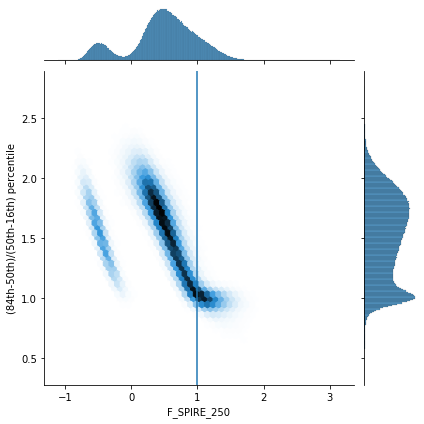

In [18]:
skew=(cat['FErr_SPIRE_250_u']-cat['F_SPIRE_250'])/(cat['F_SPIRE_250']-cat['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_250']),y=skew, kind='hex')
g.ax_joint.axvline(x=np.log10(10))

For 250 $\mathrm{\mu m}$ depth is ~ 10mJy

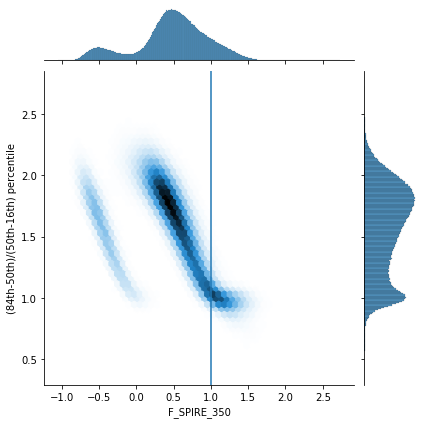

In [19]:
skew=(cat['FErr_SPIRE_350_u']-cat['F_SPIRE_350'])/(cat['F_SPIRE_350']-cat['FErr_SPIRE_350_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_350']),y=skew, kind='hex')
g.ax_joint.axvline(x=np.log10(10))

For 350 $\mathrm{\mu m}$ depth is ~ 10mJy

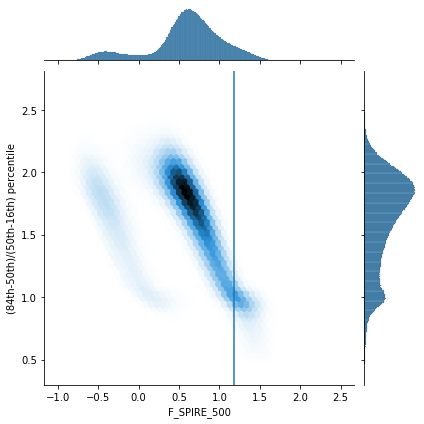

In [20]:
skew=(cat['FErr_SPIRE_500_u']-cat['F_SPIRE_500'])/(cat['F_SPIRE_500']-cat['FErr_SPIRE_500_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_500']),y=skew, kind='hex')
g.ax_joint.axvline(x=np.log10(15))

For 500 $\mathrm{\mu m}$ depth is ~ 15mJy

## Add flag to catalogue

In [21]:
from astropy.table import Column
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_250'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_350'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_500'))

In [22]:
ind_250=(cat['Pval_res_250']>0.5) | (cat['F_SPIRE_250'] < 10)
ind_350=(cat['Pval_res_350']>0.5) | (cat['F_SPIRE_350'] < 10)
ind_500=(cat['Pval_res_500']>0.5) | (cat['F_SPIRE_500'] < 15)

In [23]:
print(ind_250.sum(),ind_350.sum(),ind_500.sum(),len(cat))

1385593 1404327 1483385 1611344


In [24]:
cat['flag_spire_250'][ind_250]=True
cat['flag_spire_350'][ind_350]=True
cat['flag_spire_500'][ind_500]=True

In [25]:
cat.write('./data/dmu26_XID+SPIRE_GAMA-09_20201218.fits', format='fits',overwrite=True)

## Compare catalogue with old version

In [26]:
old_cat=Table.read('./data/dmu26_XID+SPIRE_GAMA-09_20180508.fits')

In [30]:

comparison=join(cat, old_cat, join_type='left', keys='HELP_ID')


In [31]:
comparison[0:5]

HELP_ID,RA_1,Dec_1,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_spire_250_1,flag_spire_350_1,flag_spire_500_1,RA_2,Dec_2,F_SPIRE_250_2,FErr_SPIRE_250_u_2,FErr_SPIRE_250_l_2,F_SPIRE_350_2,FErr_SPIRE_350_u_2,FErr_SPIRE_350_l_2,F_SPIRE_500_2,FErr_SPIRE_500_u_2,FErr_SPIRE_500_l_2,Bkg_SPIRE_250_2,Bkg_SPIRE_350_2,Bkg_SPIRE_500_2,Sig_conf_SPIRE_250_2,Sig_conf_SPIRE_350_2,Sig_conf_SPIRE_500_2,Rhat_SPIRE_250_2,Rhat_SPIRE_350_2,Rhat_SPIRE_500_2,n_eff_SPIRE_250_2,n_eff_SPIRE_500_2,n_eff_SPIRE_350_2,Pval_res_250_2,Pval_res_350_2,Pval_res_500_2,flag_spire_250_2,flag_spire_350_2,flag_spire_500_2
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool
HELP_J082912.113+014254.016,127.30046915959387,1.7150045197524941,0.39693213,0.8155159,0.11994268,0.39394102,0.8663631,0.10874719,0.42997402,0.91493875,0.11991834,-0.109231666,-0.20995933,-0.5336727,0.015358315,0.019849706,0.031046938,0.9982084,0.99974227,0.9985019,2532.9858,2621.8232,2334.8555,0.0,0.0,0.0,True,True,True,127.30046915959387,1.7150045197524941,3.3434353,6.5043645,1.0121498,3.250221,6.659493,0.9979752,3.582245,7.0292683,1.0280958,-0.76351494,-1.4043218,-3.3063073,0.12217842,0.14976746,0.22035134,1.0013223,0.99873,0.9983171,2000.0,2000.0,2000.0,0.0,0.0,0.0,True,True,True
HELP_J082913.120+014309.267,127.30466646191715,1.7192408866967637,0.2787379,0.6391112,0.08204828,0.22719838,0.5296609,0.05926656,0.2647525,0.6631216,0.06777302,-0.109231666,-0.20995933,-0.5336727,0.015358315,0.019849706,0.031046938,1.0007755,1.000439,0.99897,2808.6328,3314.55,2229.1128,0.0,0.0,0.0,True,True,True,127.30466646191715,1.7192408866967637,2.8483453,6.0510993,0.76234657,2.4543169,5.5245852,0.61560285,3.0331204,6.6019044,0.76873577,-0.76351494,-1.4043218,-3.3063073,0.12217842,0.14976746,0.22035134,0.9996984,0.99873585,0.9990771,2000.0,2000.0,2000.0,0.0,0.0,0.0,True,True,True
HELP_J082913.660+014249.800,127.30691774978729,1.7138334243403401,0.299406,0.62108785,0.08773412,0.2533185,0.5845494,0.07851198,0.30914402,0.66910446,0.08499264,-0.109231666,-0.20995933,-0.5336727,0.015358315,0.019849706,0.031046938,0.9986608,0.99931574,0.99900085,2158.4294,3134.415,2529.943,0.0,0.0,0.0,True,True,True,127.30691774978729,1.7138334243403401,2.9840221,6.107065,0.8193771,2.7650366,5.5439253,0.8669587,3.3376222,6.617971,1.0326357,-0.76351494,-1.4043218,-3.3063073,0.12217842,0.14976746,0.22035134,0.9994644,0.9991892,0.998812,2000.0,2000.0,2000.0,0.0,0.0,0.0,True,True,True
HELP_J082914.054+014304.068,127.3085598984684,1.717796579285437,0.25189245,0.56124663,0.06716286,0.23485509,0.52198285,0.06515569,0.2641221,0.6206795,0.07375725,-0.109231666,-0.20995933,-0.5336727,0.015358315,0.019849706,0.031046938,0.99908686,0.99880564,0.9988581,3233.612,3176.9954,2988.308,0.0,0.0,0.0,True,True,True,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
HELP_J082914.356+014322.049,127.30981575517112,1.722791294977396,0.36225504,0.703286,0.119848415,0.3433896,0.70569736,0.10136324,0.4748323,0.9096299,0.14102602,-0.109231666,-0.2099

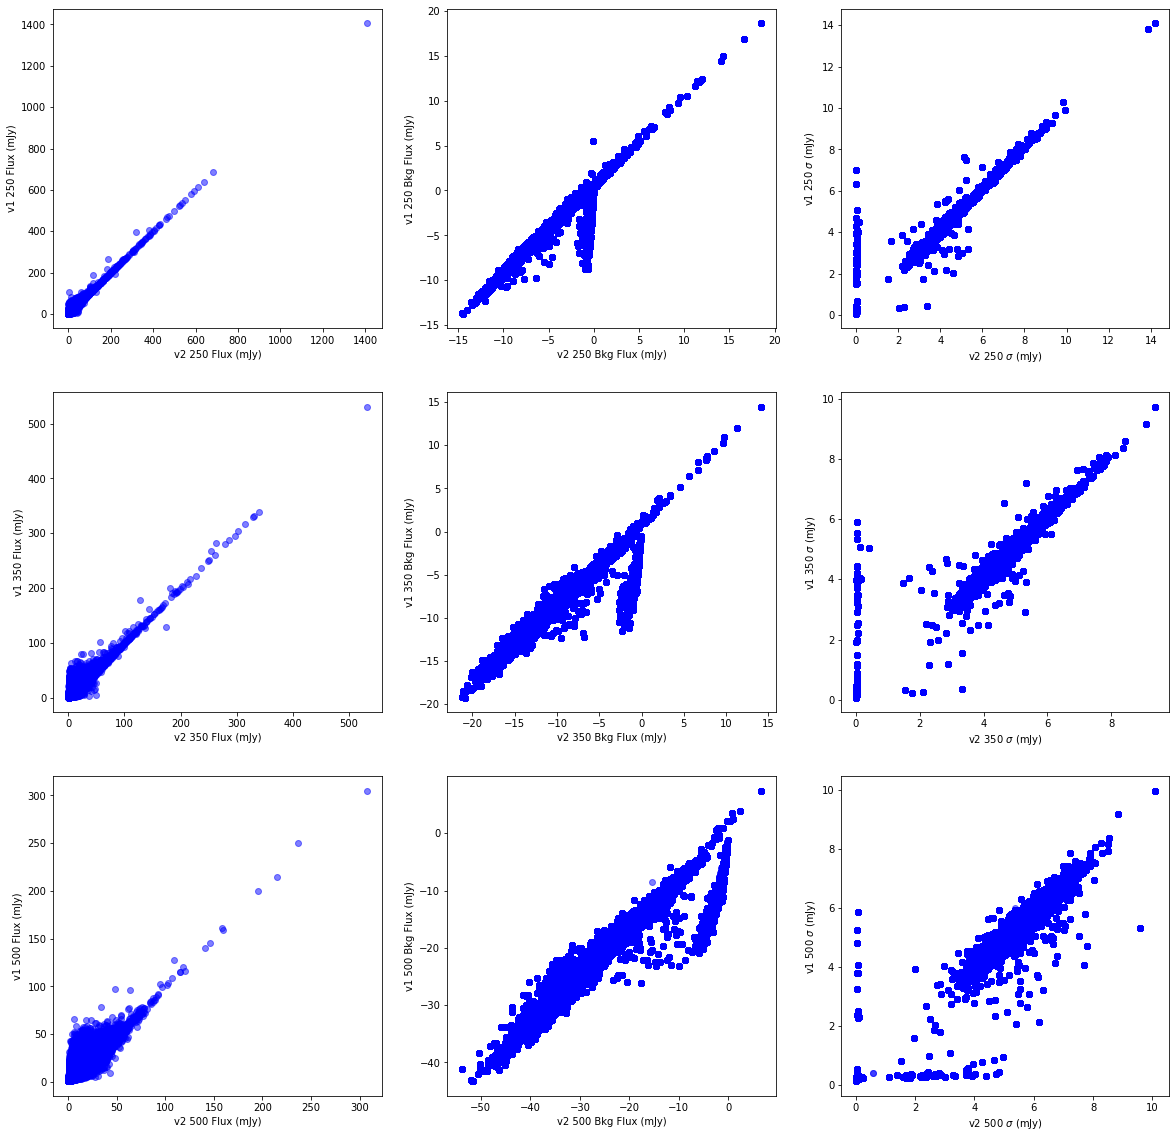

In [34]:
bands=[250,350,500]

fig,axes=plt.subplots(3,3,figsize=(20,20))
for i,b in enumerate(bands):
    axes[i,0].plot(comparison['F_SPIRE_{}_1'.format(b)],comparison['F_SPIRE_{}_2'.format(b)],'bo',alpha=0.5)
    axes[i,1].plot(comparison['Bkg_SPIRE_{}_1'.format(b)],comparison['Bkg_SPIRE_{}_2'.format(b)],'bo',alpha=0.5)
    axes[i,2].plot(comparison['Sig_conf_SPIRE_{}_1'.format(b)],comparison['Sig_conf_SPIRE_{}_2'.format(b)],'bo',alpha=0.5)
    
    axes[i,0].set_xlabel('v2 {} Flux (mJy)'.format(b))
    axes[i,0].set_ylabel('v1 {} Flux (mJy)'.format(b))
    
    axes[i,1].set_xlabel('v2 {} Bkg Flux (mJy)'.format(b))
    axes[i,1].set_ylabel('v1 {} Bkg Flux (mJy)'.format(b))
    
    axes[i,2].set_xlabel('v2 {} $\sigma$ (mJy)'.format(b))
    axes[i,2].set_ylabel('v1 {} $\sigma$ (mJy)'.format(b))

All looks good.